In [2]:
import numpy as np
import numpy.linalg as npl
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.metrics as sklm
import sklearn.model_selection as ms

# Linear Regression

In this lab, we are going to implement a Linear Regression model "by hand" and also use sklearn to implement linear regressors using different basis functions, and then add regularization to the models.



## Part 1 - Synthetic and real datasets

* Generate 50 points in a line in the interval $[0, 10]$ for `x`, perturbed by a small gaussian noise. For example, `y = 2 * x + 5 + noise` where `noise` is taken from a normal distribution.
* plot the generated data as a scatter plot, and the line without noise as a reference

*Note:* If you want to generate the same data as I generated, use $y = 3x + 5 + \epsilon$ after setting the random seed to 0

C:\Users\georg\AppData\Local\Temp\ipykernel_8372\839684558.py:14: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  plotting_df = df.melt('X', var_name='Status', value_name='Y')


<Axes: xlabel='X', ylabel='Y'>

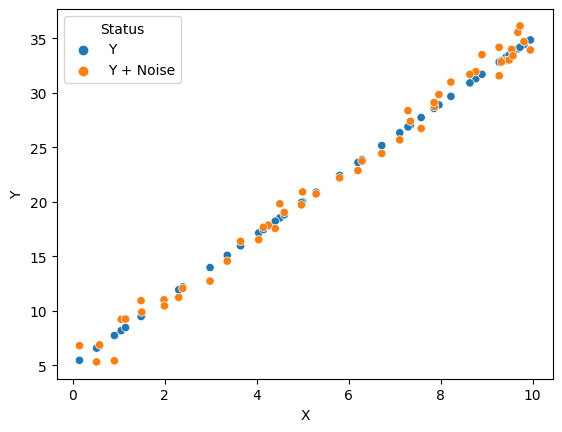

In [3]:
# your code here

#First let's create a generator with seed = 0, and generate 50 points of noise, and 50 uniform x coordinates
generator = np.random.default_rng(seed = 0)
noise = generator.normal(size = 50)
x_points = generator.uniform(high=10,size=50)

#Now i'll create 50 y coordinates with and without noise
y_clean = (3*x_points) + 5
y_noise = y_clean + noise

#Now let's use everything to plot
df = pd.DataFrame({"X": x_points, "Y": y_clean, "Y + Noise": y_noise})
plotting_df = df.melt('X', var_name='Status', value_name='Y')

sns.scatterplot(data=plotting_df, x = "X", y="Y", hue="Status")


### Load the housing dataset

For this lab we will be using the raw version of the Housing dataset that you used for the first coursework.

**Housing.txt:** this dataset is constituted by 506 points in 14 dimensions. Each point represents a house in the Boston area, and the 14 attributes that you find orderly in each column are the following:
* `CRIM` - per capita crime rate by town
* `ZN` - proportion of residential land zoned for lots over 25,000 sq.ft.
* `INDUS` - proportion of non-retail business acres per town.
* `CHAS` - Charles River dummy variable (1 if tract bounds river; 0 otherwise) 
* `NOX` - nitric oxides concentration (parts per 10 million)
* `RM` - average number of rooms per dwelling
* `AGE` - proportion of owner-occupied units built prior to 1940
* `DIS` - weighted distances to five Boston employment centres
* `RAD` - index of accessibility to radial highways
* `TAX` - full-value property-tax rate per \$10,000
* `PTRATIO` - pupil-teacher ratio by town
* `B` - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
* `LSTAT` - % lower status of the population
* `MEDV` - Median value of owner-occupied homes in $1000's

This dataset is normally associated with 2 regression tasks: predicting `NOX` (in which the nitrous oxide level is to be predicted); and predicting price `MEDV` (in which the median value of a home is to be predicted).

In [4]:
housing_names = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"]
housing = pd.read_table("data/housing.txt", names=housing_names, sep='\s+')
housing

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


## Part 2 -- Build Linear Regression Models

You will need to implement it twice:

1. using the Normal Equations seen in class (Moore-Penrose pseudo-inverse)
2. using stochastic gradient descent

* **Tip 1:** When you implement the stochastic gradient version it will be crucial to plot the sum of squares error as a function of the iteration
* **Tip 2:** You will need to initialize the weights. Start by choosing them randomly, Gaussian distributed, with a very small variance...

Run some experiments with your stochastic gradient descent version, and think about these questions: 
* what happens with different values of the step parameter? 
* Does the system always converge to the same solution? 
* Are you getting the same solution that you get with the closed form implementation? 
* What happens if you initialize your weights to values that are too big?

Below, I provide some skeletons for your implementations, but feel free to structure your code differently.

Remember to:
* Separate the datasets into training and testing (I used 60% for training)


In [5]:
def linear_regression_PI(X, y, apply_bias = True):
    """
    Implements a Linear Regression model using the Moore-Penrose pseudo-inverse
    
    Parameters
    ----------
    X : array
        A 2-dimensional array with samples in the rows and features in the columns
    y : array
        An array with the same number of elements as samples in X, the values to predict
    
    Returns
    -------
    w : array
        Learnt parameters
        
    Notes
    -----
    The first column of w corresponds to the bias (`w_0`)
    """
    # your code here
    # Let's insert the bias column
    if apply_bias:
        X = np.insert(X, 0, 1, axis=1)
    w = np.dot(np.dot(npl.inv(np.dot(X.transpose(), X)), X.transpose()), y)
    return w

# print(linear_regression_PI(housing.values[:, :-1], housing.values[:,-1]))

def linear_regression_SGD(X, y, lr, max_iter=10, apply_bias = True):
    """
    Implements a Linear Regression model using Stochastic Gradient Descent
    
    Parameters
    ----------
    X : array
        A 2-dimensional array with samples in the rows and features in the columns
    y : array
        An array with the same number of  as samples in X, the values to predict
    lr : float
        Learning rate
    max_iter : int
        number of epochs to use for the gradient descent
    
    Returns
    -------
    w : array
        Learnt parameters
    sse_history : array
        An array that contains the error of the model in every iteration
    Notes
    -----
    This function uses the gradient of the sum of squares function (Equations 3.12, and 3.23 in the Bishop book)
    """
    # your code here
    if apply_bias:
        X = np.insert(X, 0, 1, axis=1)
    w = npr.normal(0, 1, X.shape[1])
    sse_history = np.zeros(max_iter)

    for epoch in range(max_iter):
        for i in range(X.shape[0]):
            w = w + lr * (y[i] - np.dot(w.transpose(), X[i])) * X[i]
        
        sse_history[epoch] = np.sum((np.dot(X, w) - y) ** 2)/2

    return w, sse_history
    
# print(linear_regression_SGD(housing.values[:, :-1], housing.values[:, -1], 0.0000001, 10000))

we can now use this function to learn the parameters for predicting `NOX`

First you will have to prepare the data:
- Separate the features from the target variables (Put the features in a matrix X and the target variable in a vector y)
- Split the data using sklearn's train_test_split.

In [6]:
# your code here
X_train , X_test = ms.train_test_split(housing, test_size=0.4)
y_train, y_test = X_train.pop("NOX"), X_test.pop("NOX")

Now use the functions you coded to learn the weights!

In [7]:
# your code here
w_pi = linear_regression_PI(X_train.values, y_train.values)
w_sgd, history = linear_regression_SGD(X_train.values, y_train.values, 0.0000001, 10000)

make a plot that shows the evolution of the sum of squares error

**tip:** make it a callable function that you can reuse for the next task

<Axes: >

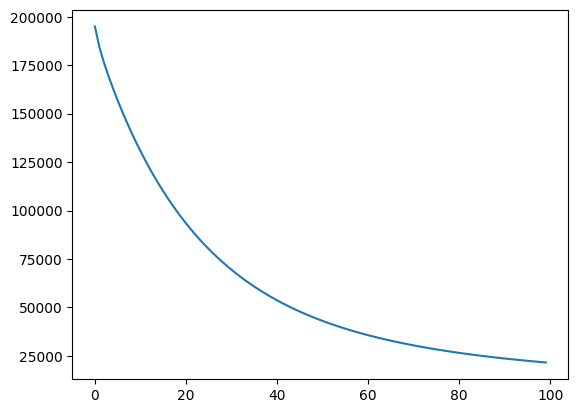

In [8]:
# your code here
sns.lineplot(history[:100])

Use the learn weights to make predictions for the test set, and evaluate the model using the root mean squared error (remember that the bias is the first column of the weight matrix)
- You can use the function you coded for your coursework, but feel free to use sklearn's `mean_squared_error()` here

In [9]:
# your code here
pred_pi = np.asarray(np.dot(X_test.values, w_pi[1:].transpose()) + w_pi[0])
pred_sgd = np.asarray(np.dot(X_test.values, w_sgd[1:].transpose()) + w_sgd[0])

mse_pi = sklm.mean_squared_error(pred_pi, y_test)
mse_sgd = sklm.mean_squared_error(pred_sgd, y_test)

print("MSE for PI: ", mse_pi)
print("MSE for SGD: ", mse_sgd)

MSE for PI:  0.00276720501585137
MSE for SGD:  3.0634030822570217


Repeat the same analysis for predicting `MEDV`

MSE for PI:  26.14435378598717
MSE for SGD:  39.537154598356736


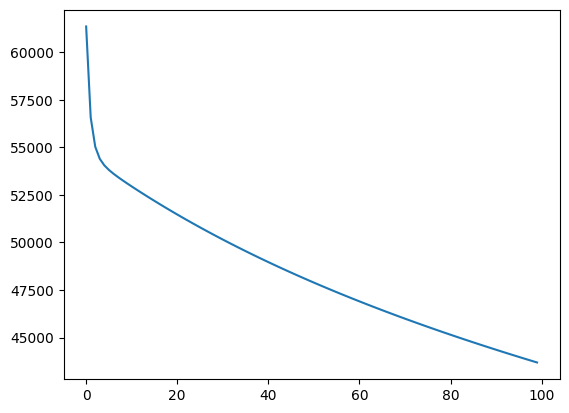

In [10]:
# your code here
# Preparing the data
X_train , X_test = ms.train_test_split(housing, test_size=0.4)
y_train, y_test = X_train.pop("MEDV"), X_test.pop("MEDV")

# Calculating w
w_pi = linear_regression_PI(X_train.values, y_train.values)
w_sgd, history = linear_regression_SGD(X_train.values, y_train.values, 0.0000001, 10000)

sns.lineplot(history[:100])

# Running the tests
pred_pi = np.asarray(np.dot(X_test.values, w_pi[1:].transpose()) + w_pi[0])
pred_sgd = np.asarray(np.dot(X_test.values, w_sgd[1:].transpose()) + w_sgd[0])

# Calculating mse
mse_pi = sklm.mean_squared_error(pred_pi, y_test.values)
mse_sgd = sklm.mean_squared_error(pred_sgd, y_test.values)

print("MSE for PI: ", mse_pi)
print("MSE for SGD: ", mse_sgd)

## Part 3 - Polynomial basis function

* Generate a 2D dataset using a sine wave (10 values for `x` in the interval $[0, 10]$), perturbed by a small gaussian noise. *Note:* To generate the same data as I generated, use $y = 4sin(x) + \epsilon$ by setting the seed to 0
* The Polynomial basis function that you will use is of the following form:
    - $\phi_i(x)=x^i$
* You will do this to create models of degrees 2, 4, and 9.
    - Transform your original `x` into the design matrix $\Phi$ by applying the basis functions to each element of `x`
    - For degree 2: $i\in[0,1,2]$, for degree 4: $i\in[0,1,2,3,4]$, and for degree 9: $i\in[0,1,2,...,9]$
    - *This means that for each Degree you will create a different $\Phi$ and fit a different regression model.*

* Plot the data and the prediction for each degree.
* Which degree of polynomial works better to model this scenario? 

Example: Let's say that $$x=\begin{bmatrix} x_1=2 \\ x_2=3 \\ x_3=1 \end{bmatrix}$$
Then for Degree 2 I will use the following basis functions: $\phi_0(x_j)=x_j^0, \phi_1(x_j)=x_j^1, \phi_2(x_j)=x_j^2$.

In this case, $\Phi$ will look like: 
$$\Phi=\begin{bmatrix} \phi_0(x_1)=x_1^0 & \phi_1(x_1)=x_1^1 & \phi_2(x_1)=x_1^2 \\ \phi_0(x_2)=x_2^0 & \phi_1(x_2)=x_2^1 & \phi_2(x_2)=x_2^2 \\ \phi_0(x_3)=x_3^0 & \phi_1(x_3)=x_3^1 & \phi_2(x_3)=x_3^2 \end{bmatrix}$$

Finally:
$$\Phi=\begin{bmatrix} 1 & 2 & 4 \\ 1 & 3 & 9 \\ 1 & 1 & 1 \end{bmatrix}$$

__*Important:* You have to code this exercise yourself.__



<Axes: >

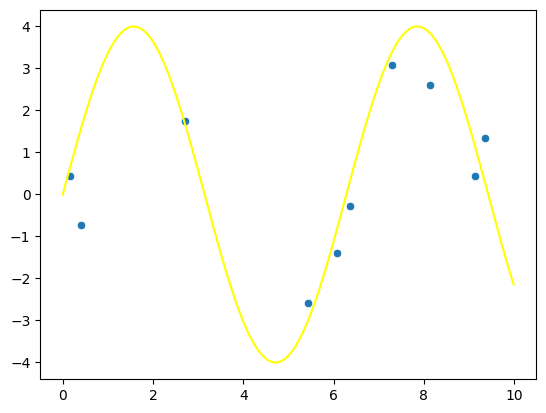

In [11]:
# your code here
generator = npr.default_rng(0)
x = generator.uniform(0, 10, 10)
y = 4*np.sin(x) + generator.normal(0, 1, 10)

sns.scatterplot(x = x, y = y)
sns.lineplot(x = np.arange(0,10,0.01), y = 4*np.sin(np.arange(0,10,0.01)), color="yellow")

(1000,)

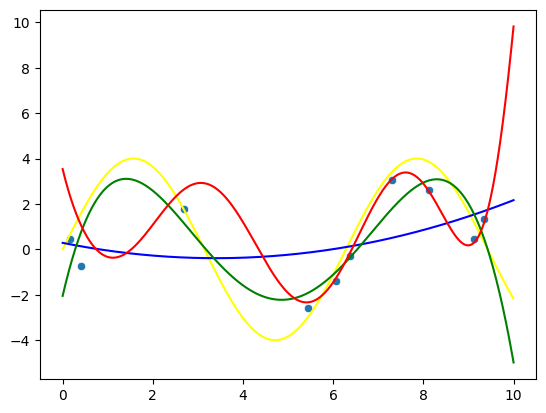

In [44]:
phi_9 = np.zeros((10, 10))

for i in range(10):
    for j in range(10):
        phi_9[i, j] = x[i]**j

phi_2 = phi_9[:, :3]
phi_4 = phi_9[:, :5]

w_sin2_pi = linear_regression_PI(phi_2, y, apply_bias = False)
w_sin4_pi = linear_regression_PI(phi_4, y, apply_bias = False)
w_sin9_pi = linear_regression_PI(phi_9, y, apply_bias = False)

w_sin2_flip = np.flip(w_sin2_pi.transpose())
w_sin4_flip = np.flip(w_sin4_pi.transpose())
w_sin9_flip = np.flip(w_sin9_pi.transpose())
linspace = np.linspace(0,10,1000)

poly2 = np.polyval(w_sin2_flip, linspace)
poly4 = np.polyval(w_sin4_flip, linspace)
poly9 = np.polyval(w_sin9_flip, linspace)

sns.scatterplot(x = x, y = y)
sns.lineplot(x = np.arange(0,10,0.01), y = 4*np.sin(np.arange(0,10,0.01)), color = "yellow")

sns.lineplot(x = linspace, y = poly2, color = "blue")
sns.lineplot(x = linspace, y = poly4, color = "green")
sns.lineplot(x = linspace, y = poly9, color = "red")



## Part 4 - Polynomial basis function

For this part you will replicate the previous part but using the existing functions from sklearn!

* Use the same data as the previous part.
* Use sklearn's Linear Regression estimator together with a Polynomial transform to make a Linear regression with a polynomial basis.

*Note:* To generate the same data as I generated, use $y = 4sin(x) + \epsilon$ by setting the seed to 0

[ 0.285545   -0.39773674  0.05856716]


<Axes: >

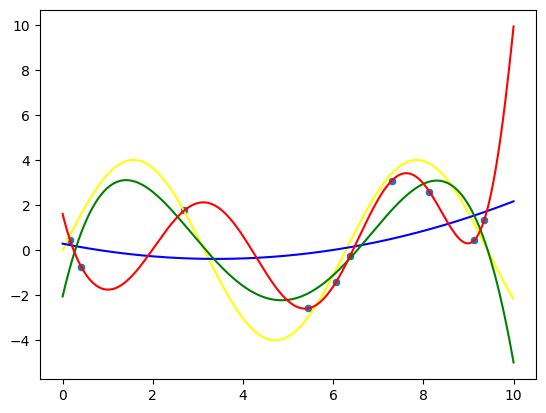

In [17]:
# your code here
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

poly2_sk = PolynomialFeatures(degree=2)
poly4_sk = PolynomialFeatures(degree=4)
poly9_sk = PolynomialFeatures(degree=9)

phi_matrix2_sk = poly2_sk.fit_transform(x.reshape(-1,1))
phi_matrix4_sk = poly4_sk.fit_transform(x.reshape(-1,1))
phi_matrix9_sk = poly9_sk.fit_transform(x.reshape(-1,1))

regr = LinearRegression()

coef2 = regr.fit(phi_matrix2_sk, y).coef_
coef4 = regr.fit(phi_matrix4_sk, y).coef_
coef9 = regr.fit(phi_matrix9_sk, y).coef_

coef2[0] = regr.fit(phi_matrix2_sk, y).intercept_
coef4[0] = regr.fit(phi_matrix4_sk, y).intercept_
coef9[0] = regr.fit(phi_matrix9_sk, y).intercept_

poly2_sk = np.polyval(np.flip(coef2), linspace)
poly4_sk = np.polyval(np.flip(coef4), linspace)
poly9_sk = np.polyval(np.flip(coef9), linspace)

sns.scatterplot(x = x, y = y)
sns.lineplot(x = np.arange(0,10,0.01), y = 4*np.sin(np.arange(0,10,0.01)), color = "yellow")

sns.lineplot(x = linspace, y = poly2_sk, color = "blue")
sns.lineplot(x = linspace, y = poly4_sk, color = "green")
sns.lineplot(x = linspace, y = poly9_sk, color = "red")

## Part 4 - Gaussian Basis (OPTIONAL)

* Create a new sklearn transformer that receives one-dimensional data and returns gaussian features based on the gaussian basis: 
$$\phi_j = \exp{\left\{-\frac{(x - \mu_j)^2}{2s^2}\right\}}$$
* The transformer should receive an argument `N` that determines the number of centers $\mu_j$ that will be used, and an argument `s` that determines the scale. As an example, if `N=10` and `s=2`, 10 equally spaced "gaussians" with space 2 will be used in the range of the input variable.
* This is not a trivial task. In a nutshell, you should be creating a new `class` that inherits `BaseEstimator` and `TransformerMixin`, and that implements both `fit` and `transform`. If you feel stuck, I recommend reading the following [documentation](https://scikit-learn.org/stable/modules/preprocessing.html#custom-transformers) and [guide](https://towardsdatascience.com/pipelines-custom-transformers-in-scikit-learn-ef792bbb3260)

* Use your Gaussian Transformer and a Linear Regression model to fit the data you generated for Part 2
* Plot the data and the predictions
* Plot the coefficients and the intersect of the linear regression model
* Using a `N=30` and `s=2.0` I get a rather overfitted model, which parameter would you choose? why?

In [96]:
# your code here
from sklearn.base import BaseEstimator, TransformerMixin

class GaussTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, s, n):
        super().__init__()
        self.means_ = None
        self.std_ = None
        self.coef_ = np.zeros(n)
        self.intersect_ = 0
        self.s = s
        self.n = n
        self.mi = np.zeros(n)
        for j in range(self.mi.size):
            self.mi[j] = (-self.s / 2) + j * self.s/(self.n-1)

    def fit(self, phi_matrix, y=None):
        phi_mock = np.insert(phi_matrix, 0, 1, axis=1)
        w = np.dot(np.dot(npl.inv(np.dot(phi_mock.transpose(), phi_mock)), phi_mock.transpose()), y)
        self.intersect_ = w[0]
        self.coef_ = w[1:] 

        return self

    def transform(self, X, y=None):
        phi_matrix = np.zeros((X.shape[0], self.n))
        for line in range(X.shape[0]):
            for column in range(self.n):
                phi_matrix[line, column] = np.exp(- ((X[line] - self.mi[column])**2 / (2 * (self.s ** 2))))

        return phi_matrix
    
    def predict(self, X):
        phi_test = self.transform(X)
        pred_y = np.dot(phi_test, self.coef_) + self.intersect_
        return pred_y

# gaussinho = GaussTransformer(2, 10)
# phi = gaussinho.transform(np.array([1,2,3]))
# phi.shape

MSE for PI:  66.3119965531098


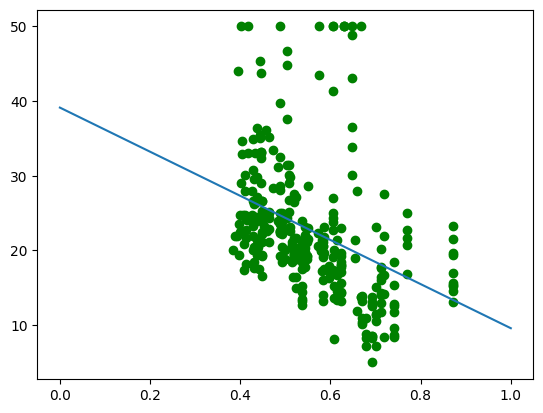

In [110]:
housing_names = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"]
housing = pd.read_table("data/housing.txt", names=housing_names, sep='\s+')
train , test = ms.train_test_split(housing, test_size=0.4)

# X_train, X_test = np.array(train["TAX"]).reshape(-1,1), np.array(test["TAX"]).reshape(-1,1)
X_train, X_test = np.array(train["NOX"]).reshape(-1,1), np.array(test["NOX"]).reshape(-1,1)
y_train, y_test = train["MEDV"], test["MEDV"]

w_pi = linear_regression_PI(X_train, y_train)

pred_pi = np.asarray(np.dot(X_test, w_pi[1:].transpose()) + w_pi[0])
mse_pi = sklm.mean_squared_error(pred_pi, y_test)
print("MSE for PI: ", mse_pi)

even_x = np.linspace(0, 1, 10000).reshape(-1,1)
even_y = np.asarray(np.dot(even_x, w_pi[1:].transpose()) + w_pi[0]).reshape(-1,1)

# sns.lineplot(x=even_x,y=even_poly)

plt.plot(even_x,even_y)
plt.scatter(X_train, y_train, color="green")
plt.show()


MSE for PI:  92.21604725661047
Coefficients: [ -733327.62225277  3263252.08658141 -1379716.35672697  2627699.12856741
  -999092.66268084 -2321128.86159933 -1051525.72312793 -1942948.81140353
  2954444.61754157 -3051541.64129833  -684292.94598505   226241.14664179
 -1258813.80590026  1066193.04335817  1282858.7538595   -621461.45661648
  1585441.87558794  2461492.64146245  -303343.20963683 -1399319.92167932
  3290138.86623348 -1425655.44046015 -1246909.04015623   767316.52493203
 -1031842.14700923   332418.86827525  2040268.47211743 -1101813.83022998
  -590991.96453253 -1160530.9693037 ]
Intersect: 281955.93067509355


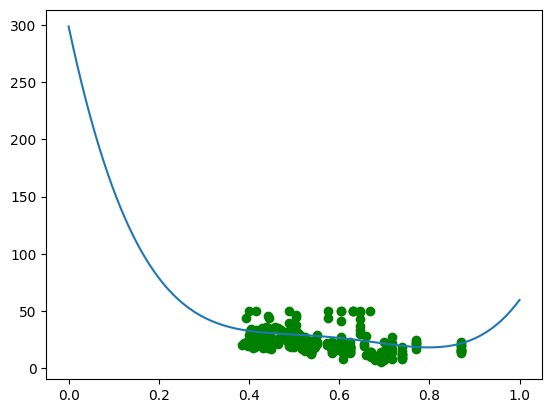

In [114]:
gauss = GaussTransformer(2,30)

phi_gauss = gauss.transform(X_train)
gauss.fit(phi_gauss, y_train)
y_pred = gauss.predict(X_test)

mse_pi = sklm.mean_squared_error(y_pred, y_test)
print("MSE for PI: ", mse_pi)

even_x = np.linspace(0,1, 10000)
even_y = gauss.predict(even_x)

print("Coefficients:", gauss.coef_)
print("Intersect:", gauss.intersect_)

plt.plot(even_x,even_y)
plt.scatter(X_train, y_train, color="green")
plt.show()